In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Creating inspector and connecting to engine
inspector = inspect(engine)

In [9]:
# Another way to get the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
columns_measure = inspector.get_columns('measurement')
for column in columns_measure:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
columns_station = inspector.get_columns('station')
for column in columns_station:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Checking Latest Date

latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest

('2017-08-23')

In [15]:
# Checking Earliest Date

earliest = session.query(Measurement.date).order_by(Measurement.date).first()
earliest

('2010-01-01')

In [16]:
# Last 12 months from file ago from today
last_12m = dt.datetime(2016, 8 , 23)
last_12m

datetime.datetime(2016, 8, 23, 0, 0)

In [70]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

results1 = session.query(Measurement.date,).\
    filter(Measurement.date > last_12m).all()

results2 = session.query(Measurement.prcp,).\
    filter(Measurement.date > last_12m).all()
    
# List of dates for last 12 months
prcp_12m_date = list(np.ravel(results1))

# List of precipitation for last 12 months
prcp_12m_prcp = list(np.ravel(results2))

# creating data frame for each
df1 = pd.DataFrame(prcp_12m_date)
df2 = pd.DataFrame(prcp_12m_prcp)

# putting on the side both dataframes
precip_df = pd.concat([df1,df2],axis=1)

precip_df.columns = ["Date", "Precipitation"]

# setting index to date

precip_df.set_index("Date", inplace=True)


precip_df.head()


,Precipitation
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


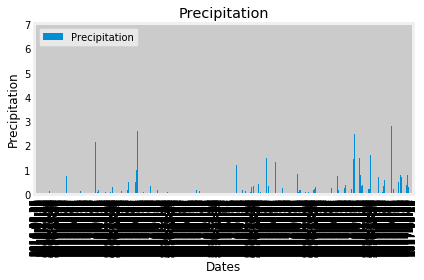

In [71]:
precip_df.plot.bar()


plt.tight_layout()
plt.title("Precipitation")
plt.xlabel("Dates")
plt.ylabel("Precipitation")
plt.tight_layout()

plt.show()



In [69]:
# Use Pandas to calcualte the summary statistics for the precipitation data

stat_summary = precip_df['Precipitation'].describe()

# Putting summary stats in dataframe

stat_summary_df = pd.DataFrame(stat_summary)
stat_summary_df

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# Design a query to show how many stations are available in this dataset?

total_stations = session.query(Station.name).count()
total_stations

9

In [26]:
station_names = session.query(Station.name).all()
station_names

[('WAIKIKI 717.2, HI US'),
 ('KANEOHE 838.1, HI US'),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('PEARL CITY, HI US'),
 ('UPPER WAHIAWA 874.3, HI US'),
 ('WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('WAIHEE 837.5, HI US'),
 ('HONOLULU OBSERVATORY 702.2, HI US'),
 ('MANOA LYON ARBO 785.2, HI US')]

In [81]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Station.station, 
       func.count(Station.station)).group_by(Station.station). order_by(Station.station).all()
active_stations


[('USC00511918', 1),
 ('USC00513117', 1),
 ('USC00514830', 1),
 ('USC00516128', 1),
 ('USC00517948', 1),
 ('USC00518838', 1),
 ('USC00519281', 1),
 ('USC00519397', 1),
 ('USC00519523', 1)]

In [89]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

station_stats = session.query(Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
station_stats


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [1]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [79]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [80]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


<IPython.core.display.Javascript object>


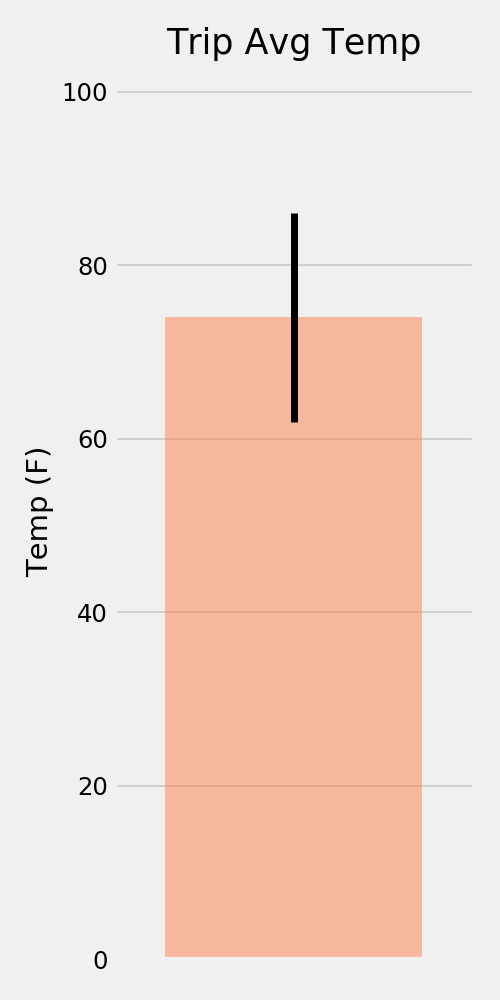

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]
